# Time Series Analysis II PII

### 05/17/2022

| $\text{Type}$     | $\text{Maturity}$                        |
| ----------------- | ---------------------------------------- |
| $\text{Bill (b)}$ | $1\text{m} \leq \text{T} \lt 1\text{Y}$  |
| $\text{Note (N)}$ | $1\text{Y} \leq \text{T} \lt 10\text{Y}$ |
| $\text{Bond (B)}$ | $\quad\quad\ \text{T} \geq 10\text{Y}$   |

## What is a Constant Maturity Treasury?

According to [Investopedia](https://www.investopedia.com/terms/c/constantmaturity.asp), Constant Maturity is an adjustment for equivalent maturity, used by the Federal Reserve Board to compute an index based on the average yield of various Treasury securities, maturing at different periods. One would use constant maturity yields as reference for pricing various kinds of depts or fixed income securities. Fixed income securities are by far the largest type of security in U.S. securities markets.

## Nominal Yield Curve Rates vs. Real Yield Curve Rates

According to the Board of Governors of the Federal Reserve System, a [nominal Treasury security](https://www.federalreserve.gov/data/nominal-yield-curve.htm) is an issuance that specifies principal and interest as fixed dollar amounts to the holder. Since Treasury securities are backed by the full faith and credit of the U.S. government, the returns investors can earn on them are often used as a “risk-free” benchmark in finance research and investment practice. These securities are a promise to repay the principal (with interest if a note or a bond) to the holder (can be a public or private entity). Therefore, the real yield curve rate would be adjusted for inflation of interest rates, thereby used to determine risk-neutral cashflow.

The **nominal yield curve rate** adds a market average of the expected inflation risk premium to the real. Investors must be compensated for the risk of inflation in bond yields. The real yield determines the cashflow an investor in secondary markets can obtain by purchasing $\text{TIPS}$, which are Inflation Protected Securities offered by the U.S. Treasury department and other stakeholders that offer similar inflation protection to investors.

## Par [Nominal] Yield Curve Rates vs. Par Real Yield Curve Rates

The **par yield** of a coupon security is the coupon rate for which the nominal value of a bond is equivalent to its market price (technically the bond price is zero, considering that the bond would have matured by this point, thereby making it worthless). On the par yield curve, the coupon rate equals the yield to maturity (YTM) of the security (ref: [Investopedia](https://www.investopedia.com/terms/p/par-yield-curve.asp) has more information). The difference between *nominal* and *real* is as described above.

## Statement of Purpose

The purpose of this time series analysis is to work on the "next steps" highlighted under `Treas TS Analysis`. These steps are as follows:

1. Time-Series Forecasting
2. Cross-Validation and Testing on New Data
3. Vector Autoregressive Fractional Integrated Moving Average
4. Markov Chain Monte Carlo
5. Heteroscedastic Models
6. Fourier Analysis and Spectral Analysis

The first step subsequent to the analysis in `Treas TS Analysis` is to do forecasting. I would need to define a "forecast origin", how many steps I can take beyond the forecast origin and what is the prediction error. Hopefully, I have better forecasts than what I obtained in `Treas Exploratory Analysis` using a "top down" approach.

The second step is done to avoid "over-fitting" (more autoregressive parameters than observations) or "under-fitting" (less autoregressive parameters than observations). For time series, regressors, also known as "explanatory variables", are the lagged W values I found earlier, under `Treas TS Analysis`. There are other variables beyond the scope of the R-CMT and N-CMT rates explored in these notebooks, such as price of any specific security (reminder that these prices are based on an index of the average yield, meaning that they are not based on the price of any particular security present in the market at the time), the average strike placed by investors, the average per capita savings, the per capita debt, the Gross National Product of the USA, &c.

The third step goes beyond ARIMA, exploring VARFIMA models. I will be making subsequent forecasts with these VARFIMA models, making cross-validations where adequate, and including an overall view of all maturities under study in a multivariate time series.

The fourth step tests both the basic ARIMA models and the VARFIMA models using the MCMC method. This is a durability test for any univariate, bivariate or multivariate distribution. Realistically, it is the posterior distribution what is being tested using the MCMC method, meaning "after the fact", after taking into account all relevant evidence or background on the particular data being examined or analyzed.

The fifth step is on Heteroscedastic Models. Here, I will be taking a deeper inspection into the "residuals" of the model in question, running variance analyses, testing for ARCH-effects, building GARCH-family models (any of GARCH, IGARCH, GARCH-M, E-GARCH, T-GARCH and CHARMA).

The sixth and last step is to run a Fourier Analysis for unimodal, bimodal, trimodal, &c., or multimodal plot of bond rates, yield curve rates, bond maturity, convexity or price. A question researchers may have is "What is the power of a bond rate?" Spectral analysis can be quite handy for testing power on a cross-sectional basis.

## Time Series Forecasting (Continued)

Earlier, in `Treas TS Analysis`, it was determined that a first order of differencing is optimal, according to the results of the Augmented Dickey-Fuller Test. A priori, I can say with `95%` confidence, that a higher order of differencing will not work for any of the $2019$ US Treasury securities analysed in this study. However, I will try with a second order of differencing, just to prove the point. I have that: 

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as mt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def maxlike(fc):
    ml = np.abs(test[2] - fc)
    d = {"mad" : [sum(ml) / len(ml)], "cv" : np.std(test) / np.mean(test)}
    return d

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

data = pd.read_csv("tnf.csv");

train = data[:int(.75*len(data)) ]
test  = data[ int(.75*len(data)):]

import itertools

ps = range(0, 8, 1)
d = 2
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

!jupyter nbextension enable --py widgetsnbextension --sys-prefix

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 2)
    each = tuple(each)
    order_list.append(each)

key = ['x5', 'x7', 'x10', 'x20', 'x30']
result_df = [optimize_ARIMA(order_list, exog=train[key[I]]) for I in range(0, 5)]

df         = pd.read_csv("tnf.csv")
key        = ['x5', 'x7', 'x10', 'x20', 'x30']

# Create Training
train = []
for i in range(0, 5):
    train.append(df[key[i]][:int(.75*len(df))])

# Create Test
test = []
for i in range(0, 5):
    test.append(df[key[i]][int(.75*len(df)):])

order_lists = []
res = iter(result_df)

for r in res:
    order_lists.append(r["(p, d, q)"])

mods = [[], [], [], [], []]
J = range(0, len(result_df[0]))

for i in range(0, 5):
    order_list = order_lists[i]
    for j in J:
        mods[i].append(ARIMA(endog=train[i], order=order_list[j]))

fits = [[], [], [], [], []]
for i in range(0, 5):
    modc = mods[i]
    for j in J:
        fits[i].append(modc[j].fit())

if len(fits[0]) == len(fits[1]) == len(fits[2]) == len(fits[3]) == len(fits[4]) == 64:
    fc_xx = [[], [], [], [], []]
    for i in range(0, 5):
        fit = fits[i]
        for j in J:
            fc_xx[i].append(fit[j].forecast(int(.25*len(data)+1), alpha=0.05))

    # ml = [[], [], [], [], []]
    ml = [((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0)]
    for i in range(0, 5):
        for j in J:
            m = maxlike(fc_xx[i][j])
            if m['mad'][0] < ml[i][1]:
                ml[i] = ((i, j), m['mad'][0])

for i in idx:
    print(fits[i][ml[i][0][1]].summary())

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
100%|██████████████████████████████████████████| 64/64 [02:03<00:00,  1.93s/it]


                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  187
Model:                 ARIMA(7, 2, 6)   Log Likelihood                 407.907
Date:                Tue, 19 Apr 2022   AIC                           -787.814
Time:                        13:15:13   BIC                           -742.729
Sample:                             0   HQIC                          -769.542
                                - 187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5688      1.509     -0.377      0.706      -3.526       2.388
ar.L2         -0.2934      1.314     -0.223      0.823      -2.869       2.283
ar.L3          0.3165      0.701      0.451      0.6

In [40]:
df         = pd.read_csv("tnf.csv")
key        = ['x5', 'x7', 'x10', 'x20', 'x30']

order_list = [(7, 2, 6), (1, 2, 2), (4, 2, 4), (4, 2, 6), (0, 2, 6)]

# Create Training
train = []
for i in range(0, 5):
    train.append(df[key[i]][:int(.75*len(data))])

# Create Test
test = []
for i in range(0, 5):
    test.append(df[key[i]][int(.75*len(data)):])

mods = []
for i in range(0, 5):
    mods.append(ARIMA(endog=train[i], order=order_list[i]))

fit = []
for mod in mods:
    fit.append(mod.fit())

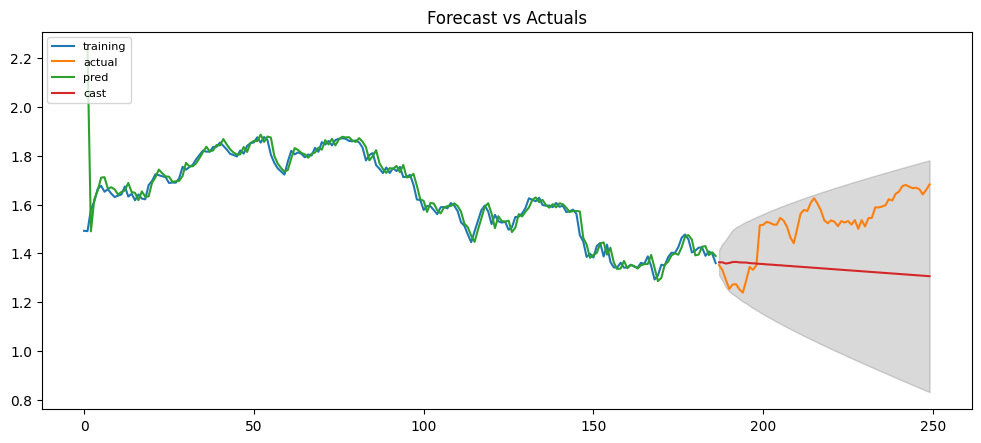

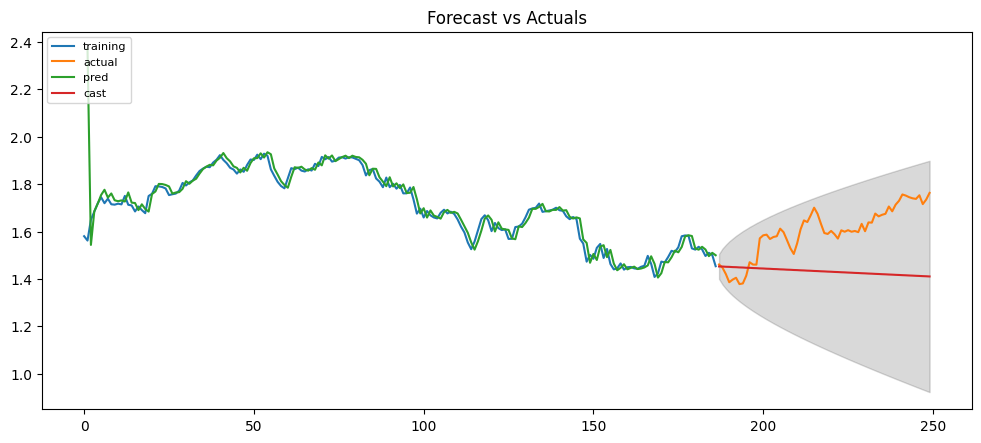

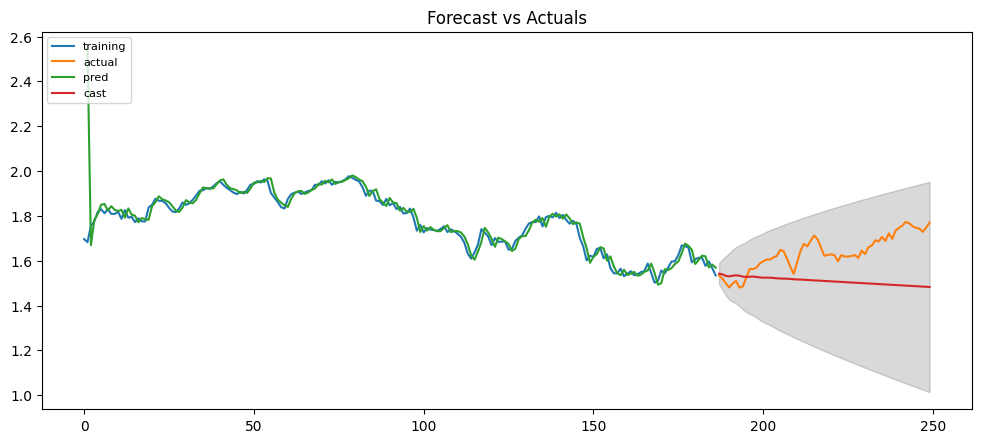

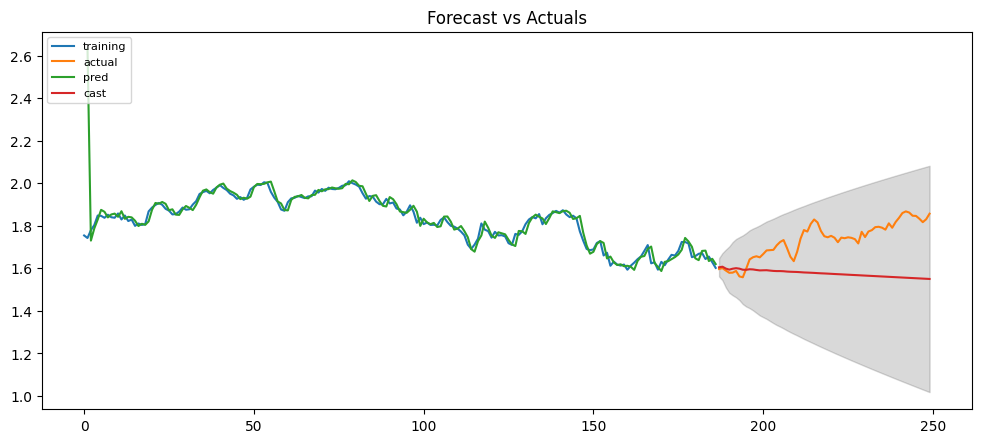

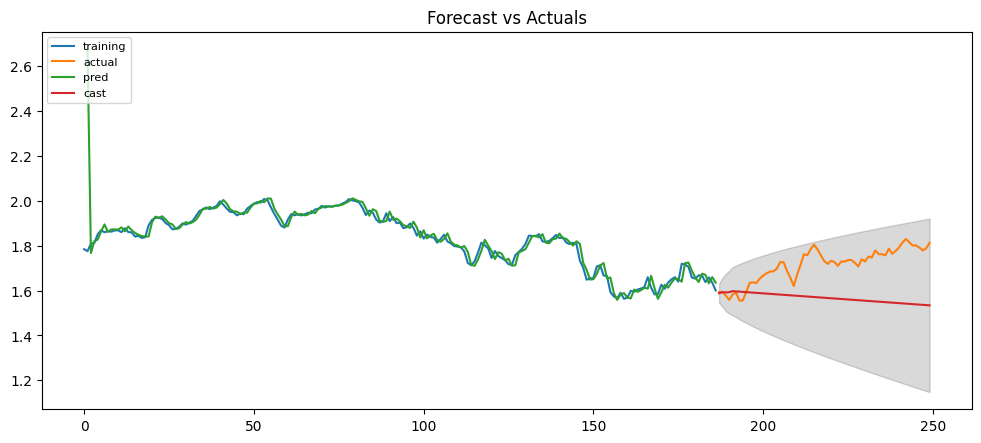

In [41]:
lo = ['lower x5', 'lower x7', 'lower x10', 'lower x20', 'lower x30']
hi = ['upper x5', 'upper x7', 'upper x10', 'upper x20', 'upper x30']

# Forecasts
pd_xx = []
fc_xx = []
fd_xx = []
fit   = []

for i in idx:
    fit.append(fits[i][ml[i][0][1]])

for f in fit:
    pd_xx.append(f.predict(1, alpha=0.05, dynamic=False))
    fc_xx.append(f.forecast(int(.25*len(data)+1), alpha=0.05))
    fd_xx.append(f.get_forecast(int(.25*len(data)+1), alpha=0.05))

idx = [0, 1, 2, 3, 4]
lower_xx_series = []; upper_xx_series = []
for I in idx:
    lower_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[lo[I]])
    upper_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[hi[I]])

# Plot
for I in idx:
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[I], label='training')
    plt.plot(test[I], label='actual')
    plt.plot(pd_xx[I], label = 'pred')
    plt.plot(fc_xx[I], label = 'cast')
    plt.fill_between(lower_xx_series[I].index, lower_xx_series[I], upper_xx_series[I],
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

I have sufficient evidence from above to conclude that the first order of differencing is optimal and there is no improvement to make on the model computed under `Treas TS Analysis II PI`. Earlier, I posed a question about whether or not ordinary least squares would be needed; not necessarily, because the ARIMA modelling approach takes care to make the best estimation possible. However, I can still filter the time series for more accurate prediction on the noise.

## Kalman Filtering on Time Series Noise

In [4]:
import pykalman
import pykalman._filter_correct

ModuleNotFoundError: No module named 'pykalman._filter_correct'

Relationship between purchasing power and interest rates

## Vector Auto-Regressive Fractional Integrated Moving Average ($\text{VARFIMA}$)

In order to get to a $\text{VARFIMA}$ model, I need to begin with $\text{VARIMA}$. Using the fitted models, in matrix form,

$
    \text{Let} \\~\\
    \quad\quad \mathcal{V} = \left(\begin{matrix} w_{t - 1} \\ w_{t - 2} \\ w_{t - 3} \\ w_{t - 4} \\ w_{t - 5} \\ w_{t - 6} \\ w_{t - 7} \end{matrix}\right) \quad \text{and} \quad \mathcal{E} = \left(\begin{matrix} \epsilon_{t - 1} \\ \epsilon_{t - 2} \\ \epsilon_{t - 3} \\ \epsilon_{t - 4} \\ \epsilon_{t - 5} \\ \epsilon_{t - 6} \\ \epsilon_{t - 7} \end{matrix}\right), \quad \text{for} \quad \mathcal{M} = \left( \begin{matrix} (7, 1, 7) \\ (3, 1, 6) \\ (3, 1, 7) \\ (6, 1, 5) \\ (3, 1, 2) \end{matrix} \right) \quad \text{with} \quad \mathcal{T} = \left( \begin{matrix} 05 \\ 07 \\ 10 \\ 20 \\ 30 \end{matrix} \right) \\~\\
    \text{Then} \\~\\
$

$$
    F(\mathcal{M}) = \left( \begin{matrix}
        -0.2883 & +0.0604 & +0.3871 & +0.0663 & +0.0847 & +0.6110 & +0.3878 \\
        -0.5369 & +0.1219 & +0.4523 & +0.0000 & +0.0000 & +0.0000 & +0.0000 \\
        -0.2955 & +0.4938 & +0.7694 & +0.0000 & +0.0000 & +0.0000 & +0.0000 \\
        -0.0971 & -0.2287 & +0.1748 & +0.0414 & +0.5051 & -0.0497 & +0.0000 \\
        +0.2214 & +0.9161 & -0.1688 & +0.0000 & +0.0000 & +0.0000 & +0.0000
    \end{matrix} \right)\mathcal{V} \quad\quad \ + \ \left( \begin{matrix}
        +0.3158 & -0.0152 & -0.4205 & -0.1625 & -0.0599 & +0.5039 & +0.4902 \\
        +0.5526 & +0.0204 & -0.4422 & -0.0458 & -0.1948 & -0.1366 & +0.0000 \\
        +0.3199 & -0.3504 & -0.7855 & -0.1419 & -0.1484 & -0.0042 & +0.1165 \\
        +0.1140 & +0.4883 & -0.2435 & -0.0559 & -0.7662 & +0.0000 & +0.0000 \\
        -0.1069 & -0.8657 & +0.0000 & +0.0000 & +0.0000 & +0.0000 & +0.0000
    \end{matrix}\right) \mathcal{E}
$$

## Fourier Analysis

Finally for a spectral analysis?

### Plotting ARIMA Model Samples for ARIMA(0, 1, 1)

I will now track the \"change of the change ($\Delta^2)$\", using an ARIMA model for the inflation of Treasury securities using the markov chains montecarlo (MCMC) method for simulating  the change of inflation rate changes for upto 10,000 iterations.

In [ ]:
@model ARIMA010(x) = begin
    T = length(x)
    μ ~ Uniform(-10, 10)
    ϕ ~ Uniform(-1, 1)
    for t in 3:T
        val = x[t-1]                  # ARIMA(0,1,0) portion"
        x[t] ~ Normal(val, 1)
    end
end

@model ARIMA110(x) = begin
    T = length(x)
    μ ~ Uniform(-10, 10)
    ϕ ~ Uniform(-1, 1)
    for t in 3:T
        val = μ +                      # Drift term"
              x[t-1] +                 # ARIMA(0,1,0) portion"
              ϕ * (x[t-1] - x[t-2])    # ARIMA(1,0,0) portion"
        x[t] ~ Normal(val, 1)
    end
end

@model ARIMA011(x) = begin
    T = length(x)
    # Set up error vector.
    ϵ = Vector(undef, T)
    x_hat = Vector(undef, T)
    θ ~ Uniform(-5, 5)
    # Treat the first x_hat as a parameter to estimate.
    x_hat[1] ~ Normal(0, 1)
    ϵ[1] = x[1] - x_hat[1]
    for t in 2:T
        # Predicted value for x.
        x_hat[t] = x[t-1] - θ * ϵ[t-1]
        # Calculate observed error.
        ϵ[t] = x[t] - x_hat[t]
        # Observe likelihood.
        x[t] ~ Normal(x_hat[t], 1)
    end
end

Employing a Markov Chain Montecarlo method to test the models I derived using **statespace modeling**.

## Plotting ARIMA Model Samples Using the Markov Chain Montecarlo (MCMC) Method

### Plotting ARIMA Model Samples for ARIMA(1, 1, 1)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(0, 1, 1)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(0, 1, 3)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(3, 1, 1)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(2, 1, 3)

Below is a plot of Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### chain_ARIMA213 = [sample(ARIMA213(s_train[:, C]), NUTS(200, 0.65), 10000) for C in 1:5]